In [2]:
import glob
import os
import subprocess
import datetime as dt
from pathlib import Path

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from mintpy import view, plot_network
from mintpy.objects import gnss, timeseries, ifgramStack
from mintpy.smallbaselineApp import TimeSeriesAnalysis
from mintpy.utils import ptime, readfile, writefile, utils as ut
from scipy import signal
from skimage.transform import rescale
from urllib.request import urlretrieve
from matplotlib.backends.backend_pdf import PdfPages


In [3]:
def get_corners(atr):
    """Get corners coordinate."""
    length = int(atr['LENGTH'])
    width = int(atr['WIDTH'])
    W = float(atr['X_FIRST'])
    N = float(atr['Y_FIRST'])
    lon_step = float(atr['X_STEP'])
    lat_step = float(atr['Y_STEP'])
    S = N + lat_step * length
    E = W + lon_step * width

    return S, N, W, E, width, length
def rescale_data(data, up, mask, meta, ref_meta):
    """rescale matrix into a different resolution"""

    # calc scaling factor
    scale = (float(meta['Y_STEP']) / float(ref_meta['Y_STEP']),
             float(meta['X_STEP']) / float(ref_meta['X_STEP']))
    
    up = np.nan_to_num(up,nan=0.0);
    # scale
    data_out = rescale(data, scale,mode='symmetric', preserve_range=True, order=0);
    mask_out = rescale(mask, scale,mode='symmetric', preserve_range=True, order=0);
    up_out = rescale(up, scale,mode='symmetric', preserve_range=True, order=0);
    data_out[mask_out==0] = np.nan;up_out[mask_out==0] = np.nan;
    # update metadata
    meta['Y_STEP'] = ref_meta['Y_STEP']
    meta['X_STEP'] = ref_meta['X_STEP']
    meta['LENGTH'], meta['WIDTH'] = data_out.shape

    return data_out, up_out, mask_out, meta

In [4]:
# better start with an ARIA product on the north most (west most) part
vel_file_list= [r'C:\Users\bvarugu\Documents\Stockton\Asc\mintpy\velocity_GNSS_integrated.h5',
                r'C:\Users\bvarugu\Documents\Concord\Asc\velocity_GNSS.h5',
               r'C:\Users\bvarugu\Documents\Lamont_Earthquake\ARIA_products\Asc\velocity_GNSS_integrated.h5',
               r'C:\Users\bvarugu\Documents\Losangeles1\Asc\mintpy\velocity_GNSS_integrated.h5',
               r'C:\Users\bvarugu\Documents\Losangeles2\Asc\mintpy\velocity_GNSS_integrated.h5',
               r'C:\Users\bvarugu\Documents\Southbay\geo\velocity_2022_2024_GNSS.h5']
mask_file_list= [r'C:\Users\bvarugu\Documents\Stockton\Asc\mintpy\maskTempCoh.h5',
                r'C:\Users\bvarugu\Documents\Concord\Asc\maskTempCoh.h5',
               r'C:\Users\bvarugu\Documents\Lamont_Earthquake\ARIA_products\Asc\maskTempCoh.h5',
               r'C:\Users\bvarugu\Documents\Losangeles1\Asc\mintpy\maskTempCoh.h5',
               r'C:\Users\bvarugu\Documents\Losangeles2\Asc\mintpy\maskTempCoh.h5',
               r'C:\Users\bvarugu\Documents\Southbay\geo\geo_maskTempCoh.h5']
geom_file_list= [r'C:\Users\bvarugu\Documents\Stockton\Asc\mintpy\geometryGeo.h5',
                r'C:\Users\bvarugu\Documents\Concord\Asc\geometryGeo.h5',
               r'C:\Users\bvarugu\Documents\Lamont_Earthquake\ARIA_products\Asc\geometryGeo.h5',
               r'C:\Users\bvarugu\Documents\Losangeles1\Asc\mintpy\geometryGeo.h5',
               r'C:\Users\bvarugu\Documents\Losangeles2\Asc\mintpy\geometryGeo.h5',
               r'C:\Users\bvarugu\Documents\Southbay\geo\geo_geometryRadar.h5']

In [5]:
insar_vel_list = []; mask_list = []; atr_list= []; insar_up_list= [];
#los_inc_angle_list =[]; los_az_angle_list = [];

for i in range(len(vel_file_list)):
    insar_vel, atr = readfile.read(vel_file_list[i],datasetName='velocity');
    mask = readfile.read(mask_file_list[i])[0];
    los_inc_angle = readfile.read(geom_file_list[i], datasetName='incidenceAngle')[0];
    los_az_angle  = readfile.read(geom_file_list[i], datasetName='azimuthAngle')[0];
    insar_up = (insar_vel)/(np.cos(np.deg2rad(los_inc_angle)));
    insar_vel_list.append(insar_vel);atr_list.append(atr);mask_list.append(mask);insar_up_list.append(insar_up)
    #los_inc_angle_list.append(los_inc_angle);los_az_angle_list.append(los_az_angle)
ref_atr = atr_list[0].copy();

In [6]:
# define the grid boundaries
S,N,W,E = 33,39,-123,-115.5
print(S,N,W,E);
ref_atr['X_STEP'] = 0.000833333; #this is equivalent ot 100m
ref_atr['Y_STEP'] = -0.000833333;
lon_step = float(ref_atr['X_STEP'])
lat_step = float(ref_atr['Y_STEP'])
width  = int(np.ceil((E - W) / lon_step))
length = int(np.ceil((S - N) / lat_step))
print('Combined matrix shape is:',length,width)    

33 39 -123 -115.5
Combined matrix shape is: 7201 9001


In [7]:
#rescale data and get combined matrix bounding box

S_bounds=[];N_bounds=[];W_bounds=[];E_bounds=[];lengths=[];widths=[];
#S_bounds.append(S1);N_bounds.append(N1);W_bounds.append(W1);E_bounds.append(E1);lengths.append(length1);widths.append(width1)
for i,atr in enumerate(atr_list):
    ratio_x = abs((float(ref_atr['X_STEP']) - float(atr['X_STEP'])) / float(ref_atr['X_STEP']))
    ratio_y = abs((float(ref_atr['Y_STEP']) - float(atr['Y_STEP'])) / float(ref_atr['Y_STEP']))
    # print(atr['FILE_PATH'],ratio_x,ratio_y)
    if any(ratio > 1e-3 for ratio in [ratio_x, ratio_y]):
        #print('file 1: X_STEP - {}, Y_STEP - {}'.format(ref_atr['X_STEP'], ref_atr['Y_STEP']))
        #print('file 2: X_STEP - {}, Y_STEP - {}'.format(atr['X_STEP'], atr['Y_STEP']))
        print('rescaling the matrix {} into the same spatial resolution as the reference grid'.format(i))
        insar_vel_list[i], insar_up_list[i], mask_list[i], atr = rescale_data(insar_vel_list[i], insar_up_list[i], mask_list[i], meta=atr, ref_meta=ref_atr);
        atr_list[i] = atr

    # input spatial extents
    print('grabbing corners of input matrices')
    S_bound, N_bound, W_bound, E_bound, width_bound, length_bound = get_corners(atr);
    S_bounds.append(S_bound);N_bounds.append(N_bound);W_bounds.append(W_bound);E_bounds.append(E_bound);lengths.append(length_bound);widths.append(width_bound);
    


grabbing corners of input matrices
grabbing corners of input matrices
grabbing corners of input matrices
grabbing corners of input matrices
grabbing corners of input matrices
rescaling the matrix 5 into the same spatial resolution as the reference grid
grabbing corners of input matrices


In [8]:
print('estimate difference in the overlapping area')
lon_seq = np.linspace(W, W + width  * lon_step, width, endpoint=False);
lat_seq = np.linspace(N, N + length * lat_step, length, endpoint=False);
lons,lats= np.meshgrid(lon_seq,lat_seq);
mat_list=[];up_mat_list = [];
for i in range(len(insar_vel_list)):
    x1, y1 = np.argmin(np.square(lon_seq - W_bounds[i])), np.argmin(np.square(lat_seq - N_bounds[i]));
    mat11 = np.zeros([length, width]) * np.nan;up_mat = np.zeros([length, width]) * np.nan;
    data = insar_vel_list[i];mask = mask_list[i]; up = insar_up_list[i];
    data[mask==0] = np.nan;up[mask==0] = np.nan;
    mat11[y1:y1+lengths[i], x1:x1+widths[i]] = data;
    up_mat[y1:y1+lengths[i], x1:x1+widths[i]] = up;
    mat_list.append(mat11);up_mat_list.append(up_mat);

estimate difference in the overlapping area


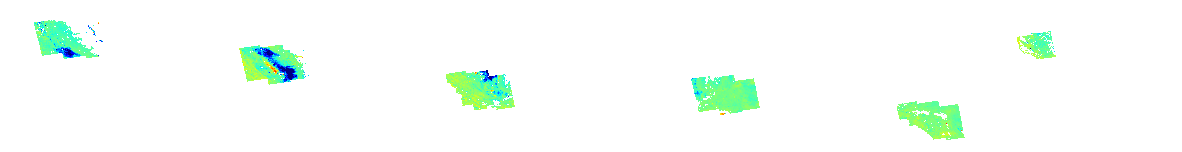

In [9]:
fig, axes = plt.subplots(1,len(mat_list),figsize=(15,10),sharey=True)
for i in range(len(mat_list)):
    ax = axes[i];
    #mat_diff = mat_list[i+1] - mat_list[i];
    ax.imshow(up_mat_list[i],cmap='jet',vmin=-0.1,vmax=0.1,interpolation='nearest')
    ax.set_axis_off()

In [10]:
mat_combined= np.zeros([len(up_mat_list),np.shape(up_mat_list[0])[0],np.shape(up_mat_list[0])[1]]);
for i in range(len(up_mat_list)):
    mat_combined[i,:,:] = up_mat_list[i];
merged_matrix = np.nanmean(mat_combined,axis=0)

C:\Users\bvarugu\AppData\Local\Temp\ipykernel_21820\3614660389.py:4: RuntimeWarning: Mean of empty slice
  merged_matrix = np.nanmean(mat_combined,axis=0)


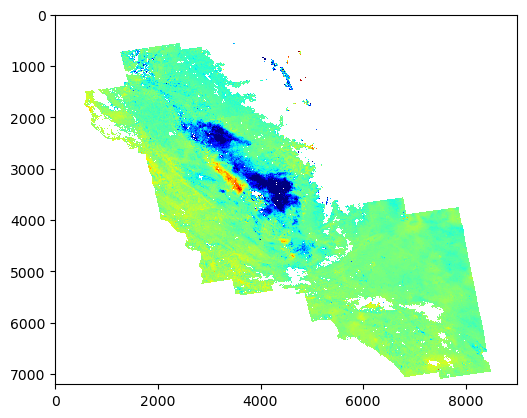

In [11]:
plt.imshow(merged_matrix,cmap='jet',vmin=-0.1,vmax=0.1,interpolation='nearest')

In [12]:
atr = dict()
for key, value in ref_atr.items():
    atr[key] = value
atr['WIDTH'] = width
atr['LENGTH'] = length
atr['X_FIRST'] = W
atr['Y_FIRST'] = N
print(f'update LENGTH/WIDTH: {length}/{width}')
print(f'update Y/X_FIRST: {N}/{W}')

# update REF_Y/X
coord = ut.coordinate(atr)
ref_y, ref_x = coord.geo2radar(float(atr['REF_LAT']), float(atr['REF_LON']))[:2]
atr['REF_Y'], atr['REF_X'] = ref_y, ref_x
print(f'update REF_Y/X: {ref_y}/{ref_x}')

# delete SUBSET_Y/XMIN/MAX
for key in ['SUBSET_XMIN', 'SUBSET_XMAX', 'SUBSET_YMIN', 'SUBSET_YMAX']:
    if key in atr.keys():
        atr.pop(key)
        print(f'remove {key}')

update LENGTH/WIDTH: 7201/9001
update Y/X_FIRST: 39/-123
update REF_Y/X: 2518/4470


In [13]:
out_file = r'C:\Users\bvarugu\Documents\Up_velocity_GNSS_integrated_merged_Dsc.h5'
dsDict = {};
dsDict['velocity'] = merged_matrix
writefile.write(dsDict, out_file=out_file, metadata=atr)

delete exsited file: C:\Users\bvarugu\Documents\Up_velocity_GNSS_integrated_merged_Dsc.h5
create HDF5 file: C:\Users\bvarugu\Documents\Up_velocity_GNSS_integrated_merged_Dsc.h5 with w mode
create dataset /velocity of float64    in size of (7201, 9001)         with compression=None
finished writing to C:\Users\bvarugu\Documents\Up_velocity_GNSS_integrated_merged_Dsc.h5


'C:\\Users\\bvarugu\\Documents\\Up_velocity_GNSS_integrated_merged_Dsc.h5'

In [14]:
import dask.array as da

from scipy.interpolate import griddata
dask_data = da.from_array(merged_matrix, chunks=(500, 500))

# Define a function for IDW interpolation over all points
def idw(chunk):
    # Get the indices of the chunk
    y, x = np.indices(chunk.shape)
    known_mask = ~np.isnan(chunk)
    known_coords = np.column_stack((x[known_mask], y[known_mask]))
    known_values = chunk[known_mask]

    # Interpolation coordinates (all points in the chunk)
    all_coords = np.column_stack((x.ravel(), y.ravel()))

    # Perform IDW interpolation
    if len(known_coords) > 0:  # Check to avoid empty data
        interpolated_values = griddata(known_coords, known_values, all_coords, method='cubic')
        interpolated_chunk = interpolated_values.reshape(chunk.shape)
    else:
        interpolated_chunk = chunk  # Leave as-is if no known points

    return interpolated_chunk

# Apply the IDW function to each chunk
interpolated = dask_data.map_blocks(idw, dtype=float).compute()

# Results
print("Interpolated Array:")

Interpolated Array:


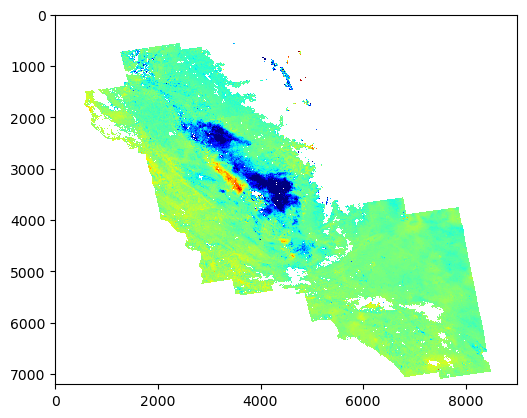

In [15]:
nann_mask = np.isnan(merged_matrix)
interpolated[nann_mask]=np.nan
plt.imshow(interpolated,cmap='jet',vmin=-0.1,vmax=0.1,interpolation='nearest')

In [16]:
out_file = r'C:\Users\bvarugu\Documents\Up_velocity_GNSS_integrated_merged_Asc_interpolated.h5'
dsDict = {};
dsDict['velocity'] = interpolated
writefile.write(dsDict, out_file=out_file, metadata=atr)

delete exsited file: C:\Users\bvarugu\Documents\Up_velocity_GNSS_integrated_merged_Asc_interpolated.h5
create HDF5 file: C:\Users\bvarugu\Documents\Up_velocity_GNSS_integrated_merged_Asc_interpolated.h5 with w mode
create dataset /velocity of float64    in size of (7201, 9001)         with compression=None
finished writing to C:\Users\bvarugu\Documents\Up_velocity_GNSS_integrated_merged_Asc_interpolated.h5


'C:\\Users\\bvarugu\\Documents\\Up_velocity_GNSS_integrated_merged_Asc_interpolated.h5'

In [17]:
# i=1;
# insar_vel, atr = readfile.read(vel_file_list[i],datasetName='velocity');
# mask = readfile.read(mask_file_list[i])[0];
# los_inc_angle = readfile.read(geom_file_list[i], datasetName='incidenceAngle')[0]
# los_az_angle  = readfile.read(geom_file_list[i], datasetName='azimuthAngle')[0]
# horz_az_angle=-90
# (length,width) = insar_vel.shape
# dhorz = np.zeros((length, width), dtype=np.float32) * np.nan
# dvert = np.zeros((length, width), dtype=np.float32) * np.nan

# step = 20;
# num_row = np.ceil(length / step).astype(int)
# num_col = np.ceil(width / step).astype(int)

# for i in range(num_row):
#     y0, y1 = step * i, min(step * (i + 1), length)
#     for j in range(num_col):
#         x0, x1 = step * j, min(step * (j + 1), width)

#         # calculate the median geometry for the local window
#         med_los_inc_angle = np.nanmedian(los_inc_angle[y0:y1, x0:x1], axis=(0,1))
#         med_los_az_angle  = np.nanmedian(los_az_angle[y0:y1, x0:x1], axis=(0,1))
#         if np.all(~np.isnan(med_los_inc_angle)):
#             print(med_los_inc_angle,med_los_az_angle)

#             G = np.zeros((1, 2), dtype=np.float32);
#             G[0, 0] = np.sin(np.deg2rad(med_los_inc_angle)) * np.cos(np.deg2rad(med_los_az_angle - horz_az_angle));
#             G[0, 1] = np.cos(np.deg2rad(med_los_inc_angle))
#             dhv = np.dot(np.linalg.pinv(G), insar_vel[y0:y1, x0:x1].reshape(1,-1))
#             dhorz[y0:y1, x0:x1] = dhv[0].reshape(y1-y0, x1-x0)
#             dvert[y0:y1, x0:x1] = dhv[1].reshape(y1-y0, x1-x0)

In [18]:
print(med_los_inc_angle,med_los_az_angle)
print(G)
print(np.linalg.pinv(G))
print(insar_vel[y0:y1, x0:x1].reshape(1,-1))
print(dhv)


NameError: name 'med_los_inc_angle' is not defined

In [ ]:
plt.imshow(dvert,cmap='jet',vmin=-0.05,vmax=0.05)

In [ ]:
insar_up = (insar_vel)*(np.cos(np.deg2rad(los_inc_angle)))
plt.imshow(insar_up,cmap='jet',vmin=-0.05,vmax=0.05,interpolation='nearest')